## 1. Introduction

In this notebook we will examine the performance of various deep learning models on a medium sized NLP dataset. We will compare a 'classic' neural network model, an LSTM model and we will even use a Transformers model.

For all 3 models we will perform some hyperparameter tuning to study the effect that a varying learning rate has on the validation loss and accuracy.

The main questions we would like to answer are:
1. What is the maximum accuracy score on the validation set for each of the 3 models?
2. What is the effect of varying the learning rate for each of the 3 models?

The comparison will not be an exact comparison as both the neural network model and the LSTM model are trained from scratch and use a different tokenization method compared to the DistilBert model which was pretrained on Gigabytes of text. This difference will give us some insights into the effect of using a pretrained model compared to training from scratch.

The DistilBert model was chosen as it is one of the smallest Transformers models available on the Huggingface site while still giving a good performance.

Note! I used the same dataset also in my final project for course DTSA5510. There I used it to determine the performance achieved with unsupervised models and a non deep learning GradientBoostingClassifier. The classification performances achieved with those methods ranged from 29% to 75%. It will be very interresting to see how deep learning might push the maximum performance even further.

If you would like to rerun this notebook than take into account a runtime of a few hours on a high-end notebook or desktop. A recent NVidia GPU is also required to be able to run it in a few hours. A 8GB RAM GPU should be enough to fit the Transformers DistilBert Model.

Next let's start with importing all the required Python modules.

In [1]:
# Import Modules
import gc
import numpy as np
import os
import pandas as pd
import tarfile
import time
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from urllib.request import urlopen

# NLTK for English Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Tensorflow
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Huggingface Transformers
from transformers import AutoConfig, AutoTokenizer, TFDistilBertForSequenceClassification

# Pandas Display Settings
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Dataset

The dataset I've chosen to use is a medium sized dataset containing news articles. The dataset is a subset of the AG news dataset and contains a subset of the articles. The original AG news dataset contains about 1 million news articles. The AG News Subset contains a training file with 120K news articles and a test file with 7600 news articles.

Originally the AG News Subset is a part of the [Tensorflow Datasets - AG_news_subset](https://www.tensorflow.org/datasets/catalog/ag_news_subset). I've re-used some of the original TF dataset code to be able to download the original text/csv files and not use the TFRecords files that the Tensorflow Datasets normally provide.

For each news article the datasets contain a:
1. title
2. description
3. label

The labels are in a range of 1 - 4. To allow for easy using all labels are subtracted with 1 to modify the range to be within 0 - 3.

On data loading the class names for each label are merged with the training and test files. The following categories are present in the dataset:
1. World = 0
2. Sports = 1
3. Business = 2
4. Sci/Tech = 3

Lets get started by downloading and parsing the dataset and moving on to the Exploratory Data Analysis.

In [2]:
# AG News Subset Download URL from TFDS
AGNEWSSUBSET_URL = 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms'
AGNEWSSUBSET_DIR = './' 

# Download Tar.Gz File and Extract
with urlopen(AGNEWSSUBSET_URL) as targzstream:
    thetarfile = tarfile.open(fileobj = targzstream, mode = "r|gz")
    thetarfile.extractall(AGNEWSSUBSET_DIR)
    
# List Dataset files
agnewssubset_files = os.listdir(AGNEWSSUBSET_DIR + 'ag_news_csv/')
print(agnewssubset_files)

# Load Train Csv
train_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/train.csv', names = ['label', 'title', 'description'])
train_df = train_df.sample(frac = 1.0, random_state = 42) 

# Load Test Csv
test_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/test.csv', names = ['label', 'title', 'description'])

# Modify Labels to range 0 .. n-1
train_df.label = train_df.label - 1
test_df.label = test_df.label - 1

# Load Classes
classes_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/classes.txt', names = ['category'], delimiter = "\t")

# Join Classes to Train and Test
classes_df['label'] = classes_df.index
train_df = classes_df.merge(train_df)
test_df = classes_df.merge(test_df)

['classes.txt', 'readme.txt', 'test.csv', 'train.csv']


## 3. Exploratory Data Analysis

In this EDA we will take a closer look at the dataset we will be using. First let's examine the shape of the training dataset.

In [3]:
train_df.shape

(120000, 4)

We can see we have 120K of rows (as already stated in the previous dataset description) and 4 different columns.

Let's look at a few records from the training dataset.

In [4]:
train_df.head(10)

,category,label,title,description
0,World,0,Google Cuts Its IPO Price Range,"SAN JOSE, Calif. - In a sign that Google Inc.'s initial public offering will not be as hot or big as expected, the Internet search giant slashed its estimated per-share price range and reduced the number of shares to be sold by insiders..."
1,World,0,US genocide charge is Bush election ploy - Sudan FM (AFP),AFP - Sudan's foreign minister rejected US charges of genocide in the western region of Darfur as a reelection ploy by US President George W. Bush.
2,World,0,Stop croc water swimming: coroner,"THE public still did not appreciate how frighteningly dangerous crocodiles were, even after the fatal mauling of a German tourist two years ago, a coroner said today."
3,World,0,Construction Spending Hits All-Time High,"WASHINGTON - Construction spending surged in August to the highest level on record, while manufacturing grew at a slower pace in September, offering mixed signals about the economy's strength. The Commerce Department reported Friday that the value of buildings put in place clocked in at a seasonally adjusted annual rate of \$1.02 trillion, a record high..."
4,World,0,US Considering Incentives for Iran,"Resigning Iranian Vice-President Mohammad Ali Abtahi, center, and newly appointed Vice-President Majid Ansari, second left, attend a meeting of the central council of their party President Mohammad Khatami accepted Abtahi #39;s resignation, in Tehran, Iran"
5,World,0,In Our View: Sanctions not enough for Sudan,"While most of the country #39;s attention has been focused on Iraq, a human-rights crisis has been unfolding in north Africa. In Darfur, Sudan, more than 50,000 people have been killed and 1.2 million displaced"
6,World,0,Apex court permits night viewing of Taj Mahal:,"India News: New Delhi, Nov 25 : The Supreme Court Thursday permitted the Uttar Pradesh government to allow visitors to view the Taj Mahal on five moonlit nights a month."
7,World,0,Man dies in blast as Chechens go to polls,"OISKHARA, Russia - A man tried to bring a suspicious package into a polling station in Chechnya on Sunday, then died in an explosion as he ran away, the head of the Chechen election commission said on Russian television."
8,World,0,Barghouthi Pulls Out of Palestinian Election,"Jailed Palestinian uprising leader Marwan Barghouthi has pulled out of a Jan. 9 presidential election to succeed Yasser Arafat, a close aide said on Sunday."
9,World,0,Afghanistan takes first difficult steps toward democracy,The election for president in Afghanistan may have brought us one small step closer to worldwide democracy. At least the people there left no doubt that they wanted to vote.


We can see a number of sample records with the 'category' and 'label' for 'World' related news. The sample titles are fairly short and also the description seems to be not really lengthy.

We will take a further look at the word count distribution for 'title' and 'description' in a second.

First let's see how our labels are distributed.

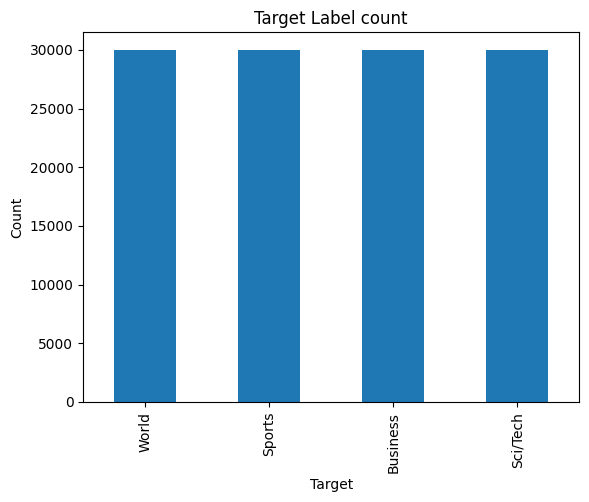

In [5]:
# Plot Label count
train_df.category.value_counts().plot(kind = 'bar')
plt.title('Target Label count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

All of the labels are equally distributed. For each label there are a total of 30K of sample records.

We don't have todo any pre-processing to get equally distributed labels.

Next let's look at the test dataset shape.

In [6]:
test_df.shape

(7600, 4)

The test dataset contains 7600 records and again 4 columns.

Let's take a look at some test dataset samples.

In [7]:
test_df.head(10)

,category,label,title,description
0,World,0,Sister of man who died in Vancouver police custody slams chief (Canadian Press),Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.
1,World,0,"Man Sought #36;50M From McGreevey, Aides Say (AP)","AP - The man who claims Gov. James E. McGreevey sexually harassed him was pushing for a cash settlement of up to #36;50 million before the governor decided to announce that he was gay and had an extramarital affair, sources told The Associated Press."
2,World,0,Explosions Echo Throughout Najaf,"NAJAF, Iraq - Explosions and gunfire rattled through the city of Najaf as U.S. troops in armored vehicles and tanks rolled back into the streets here Sunday, a day after the collapse of talks - and with them a temporary cease-fire - intended to end the fighting in this holy city..."
3,World,0,Frail Pope Celebrates Mass at Lourdes,"LOURDES, France - A frail Pope John Paul II, breathing heavily and gasping at times, celebrated an open-air Mass on Sunday for several hundred thousand pilgrims, many in wheelchairs, at a shrine to the Virgin Mary that is associated with miraculous cures. At one point he said ""help me"" in Polish while struggling through his homily in French..."
4,World,0,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.
5,World,0,1994 Law Designed to Preserve Guard Jobs (AP),AP - A 1994 law strengthened job protections for National Guard and Reserve troops called to active duty. Here are major provisions of the Uniformed Services Employment and Reemployment Rights Act (USERRA).
6,World,0,Iran Warns Its Missiles Can Hit Anywhere in Israel,"TEHRAN (Reuters) - A senior Iranian military official said Sunday Israel and the United States would not dare attack Iran since it could strike back anywhere in Israel with its latest missiles, news agencies reported."
7,World,0,Afghan Army Dispatched to Calm Violence,"KABUL, Afghanistan - Government troops intervened in Afghanistan's latest outbreak of deadly fighting between warlords, flying from the capital to the far west on U.S. and NATO airplanes to retake an air base contested in the violence, officials said Sunday..."
8,World,0,Politics an Afterthought Amid Hurricane (AP),"AP - If Hurricane Charley had struck three years ago, President Bush's tour through the wreckage of this coastal city would have been just the sort of post-disaster visit that other presidents have made to the scenes of storms, earthquakes, floods and fires."
9,World,0,"Venezuelans Flood Polls, Voting Extended","CARACAS, Venezuela (Reuters) - Venezuelans voted in huge numbers on Sunday in a historic referendum on whether to recall left-wing President Hugo Chavez and electoral authorities prolonged voting well into the night."


This gives the same impression as the training dataset. Looking at some of the descriptions it is clear that this is already a bit older dataset with news articles of around 2004 - 2006 (President George Bush, President Hugo Chaves, the Iraq war etc).

Let's look at the label distribution for the test dataset.

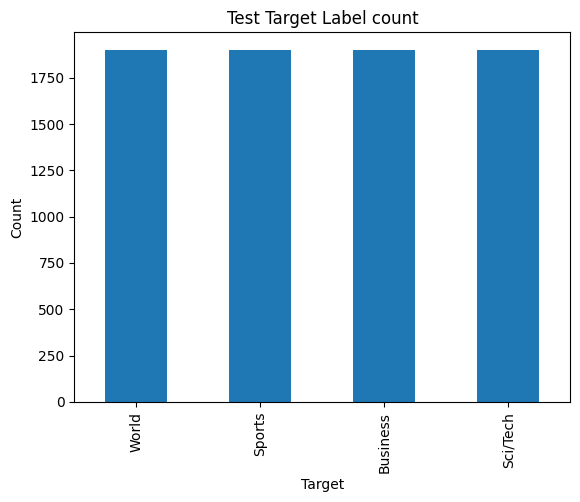

In [8]:
# Plot Label count
test_df.category.value_counts().plot(kind = 'bar')
plt.title('Test Target Label count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The labels for the test dataset also have an equal distribution.

Next let's take a look at the distribution of the word count for each of the sample 'description'.

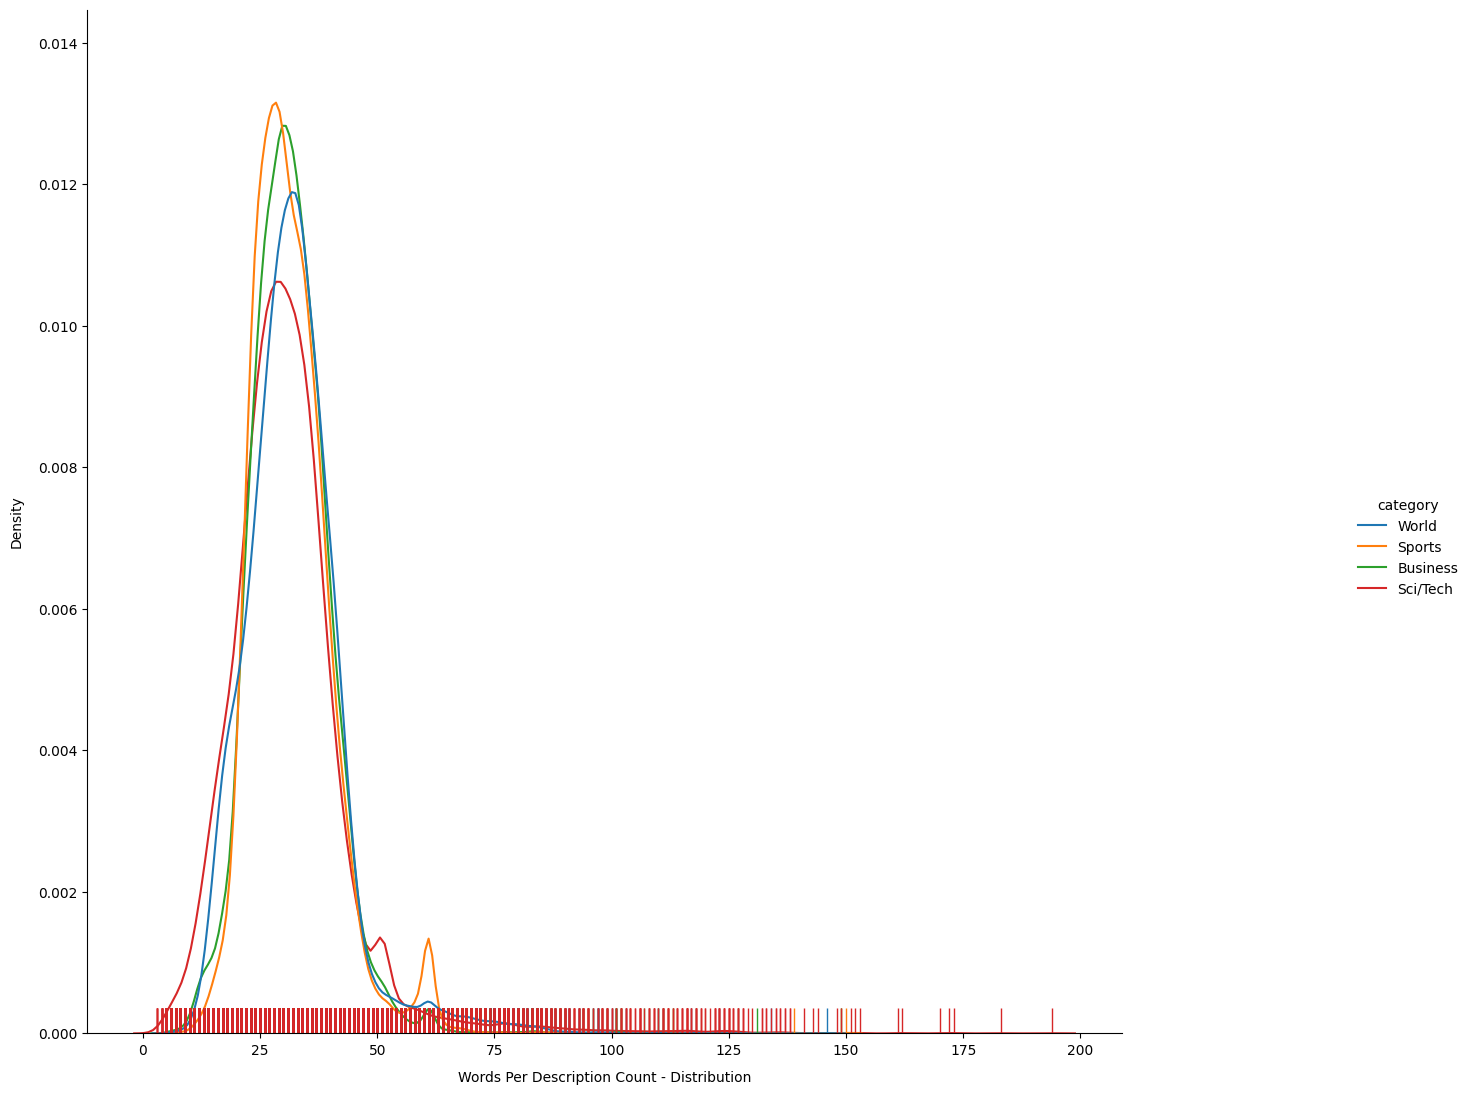

In [9]:
# Plot Description Text Word Count
train_df['description_word_count'] = train_df.description.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'description_word_count', hue = 'category')
g.set_axis_labels('Words Per Description Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of the descriptions have a word count ranging between 0 and 50 with a very few exceptions spiking up to 200 words in the description.

The distribution of the word count when looking at the specific labels is for the most part comparable.

Even though in this notebook we won't be using the 'title' it is still interresting to look at the word count distribution for it.

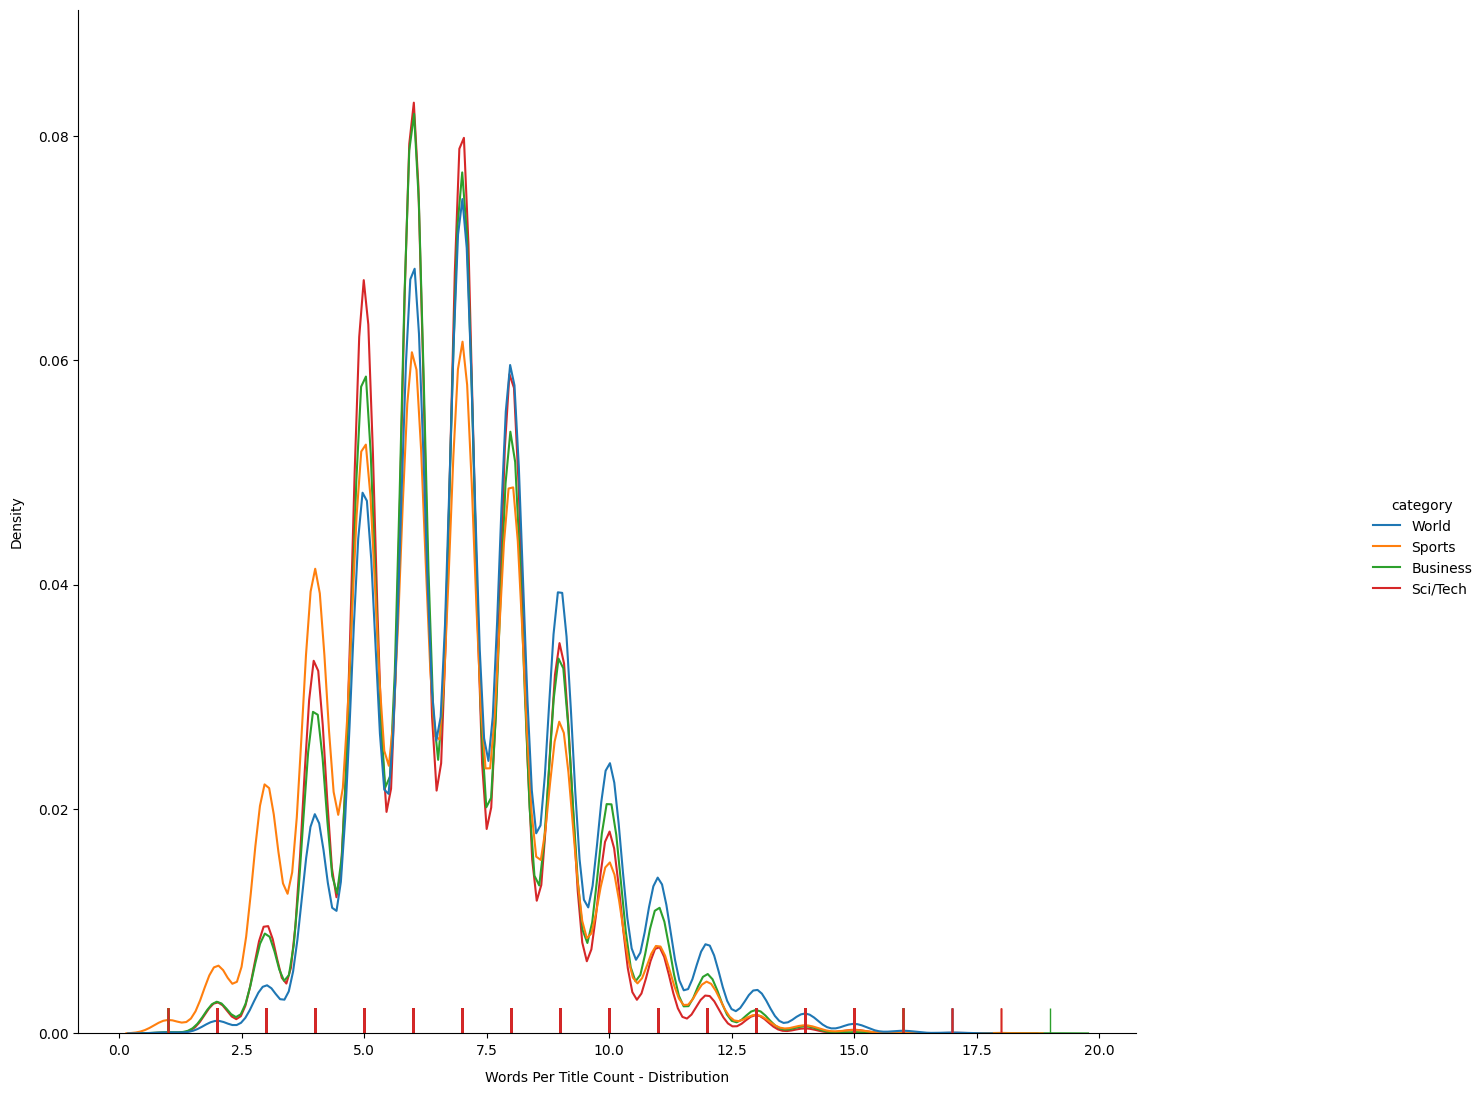

In [10]:
# Plot - Title Text Word Count
train_df['title_word_count'] = train_df.title.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'title_word_count', hue = 'category')
g.set_axis_labels('Words Per Title Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of the titles have a word count ranging between 2 - 11. The distribution per label is very similar.

We have now some insights into the number of words per title and description. 

The title we won't be using in this notebook. The description will be used extensively however...currently no text cleaning has been done.

For the neural network model and the LSTM model we will clean the text. For the DistilBert model however we will keep the text input as-is. Because Transformer models are pretrained on Gigabytes of normal text it could actually hurt performance if we clean the text. The sentences that the DistilBert model would then be trained on are not recognizable compared to the original text that was used for the pretraining.

Next we will perform some text cleaning steps:

1. Lowercase all text.
2. Remove all English Stopwords. These usually have a high occurence but add very little value.

No further text cleaning will be done.

In [11]:
# Lowercase all text
train_df['description_cleaned'] = train_df.description.apply(str.lower)

# Remove all Stopwords.
train_df['description_cleaned'] = train_df['description_cleaned'].apply(lambda x: ' '.join([stopword for stopword in x.split() if stopword not in (english_stopwords)]))

Now that the training dataset has been cleaned it is interresting to again look at the distribution of word count for the cleaned description texts. With the stopwords cleaned a lot of the descriptions should be shorter and hence have a lower word count.

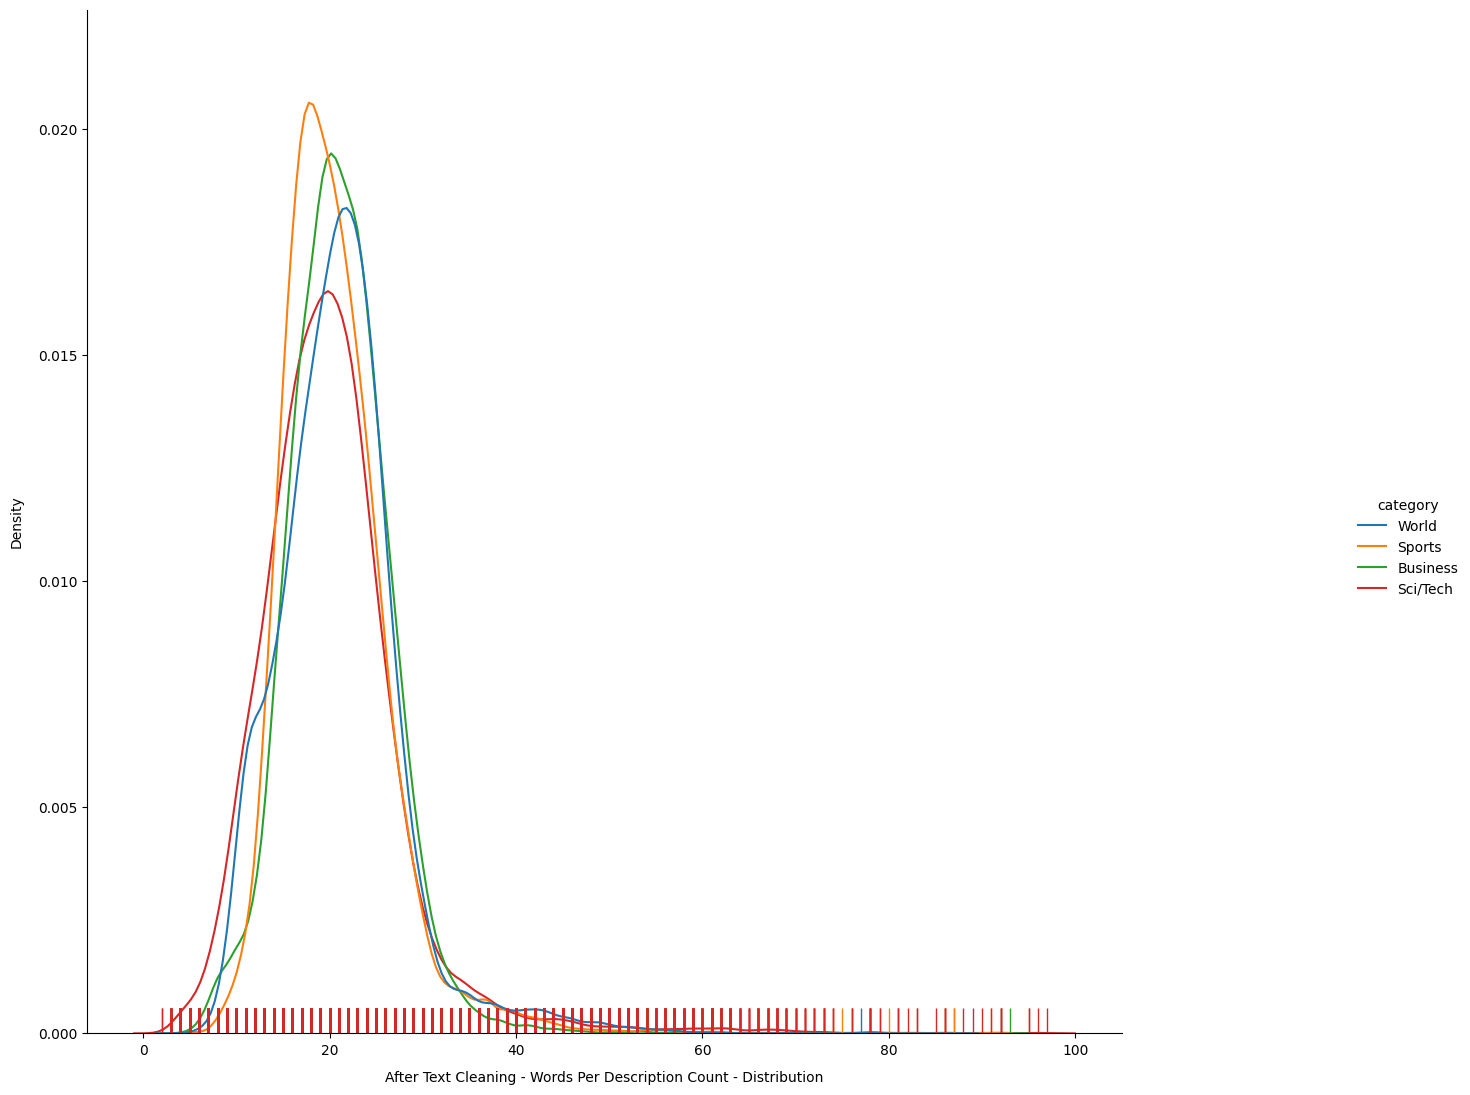

In [12]:
# Plot - Title Text Word Count
train_df['description_cleaned_word_count'] = train_df.description_cleaned.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'description_cleaned_word_count', hue = 'category')
g.set_axis_labels('After Text Cleaning - Words Per Description Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of articles now have a word count between 0 and 40 with some outliers up to a maximum of 100 words per description.

The distribution of word count when looking at the labels is still mostly similar. Based on the distribution of the word count per label there is no need to do any processing or other data cleaning.

## 4. Models, Training and Hyperparameter tuning



In the following section we setup a few supporting functions that will be called repetitively.

In [13]:
def keras_vectorize_text(df, max_words, max_length):
    tokenizer = Tokenizer(num_words = max_words,
                          filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower = True,
                          split = ' ',
                          char_level = False,
                          oov_token = None,
                          analyzer = None)

    # Randomize samples
    df = df.sample(frac = 1.0)
    
    # Tokenize fit on texts
    tokenizer.fit_on_texts(df.description_cleaned.values)

    # Prepare text
    X = tokenizer.texts_to_sequences(df.description_cleaned.values)

    # Truncate / Pad text for fixed length for LSTM / GRU
    X = pad_sequences(X, maxlen = max_length)

    # Set Target
    y = df.label.values
    y = to_categorical(y, num_classes = 4, dtype = 'float32')

    return tokenizer, X, y

def plot_results_accuracy(title, epochs, learning_rates, history_val_acc_list, history_trn_acc_list):
    # Prep
    epochs_list = [*range(1, epochs + 1, 1)]
    
    # Plot results for 6 models
    plt.figure(figsize=(12, 8)) 
    plt.xlabel("Epoch")
    plt.xticks(epochs_list)
    plt.ylabel("Accuracy Score")
    plt.title(f"{title} - Training and Validation Accuracy Plot - All {len(learning_rates)} Model Scores")
    
    for i in range(len(history_val_acc_list)):
        plt.plot(epochs_list, history_val_acc_list[i], label = f"Val Acc LR: {learning_rates[i]}")
        plt.plot(epochs_list, history_trn_acc_list[i], label = f"Train Acc LR: {learning_rates[i]}")
        
        max_valacc_x = np.argmax(history_val_acc_list[i]) + 1
        max_valacc_y = np.max(history_val_acc_list[i])
        max_trnacc_x = np.argmax(history_trn_acc_list[i]) + 1
        max_trnacc_y = np.max(history_trn_acc_list[i])
            
        plt.scatter(max_trnacc_x, max_trnacc_y, label = f"Max Train Acc LR: {learning_rates[i]}")
        plt.scatter(max_valacc_x, max_valacc_y, label = f"Max Val Acc LR: {learning_rates[i]}")
        
    plt.legend(bbox_to_anchor = (1.05, 1), borderaxespad = 0)
    plt.show()

def plot_results_loss(title, epochs, learning_rates, history_val_loss_list, history_trn_loss_list):
    # Prep
    epochs_list = [*range(1, epochs + 1, 1)]
    
    # Plot results for 6 models
    plt.figure(figsize=(12, 8)) 
    plt.xlabel("Epoch")
    plt.xticks(epochs_list)
    plt.ylabel("Loss Score")
    plt.title(f"{title} - Training and Validation Loss Plot - All {len(learning_rates)} Model Scores")
    
    for i in range(len(history_val_loss_list)):
        plt.plot(epochs_list, history_val_loss_list[i], label = f"Val Loss LR: {learning_rates[i]}")
        plt.plot(epochs_list, history_trn_loss_list[i], label = f"Train Loss LR: {learning_rates[i]}")
        
        min_valloss_x = np.argmin(history_val_loss_list[i]) + 1
        min_valloss_y = np.min(history_val_loss_list[i])
        min_trnloss_x = np.argmin(history_trn_loss_list[i]) + 1
        min_trnloss_y = np.min(history_trn_loss_list[i])
            
        plt.scatter(min_trnloss_x, min_trnloss_y, label = f"Min Train Loss LR: {learning_rates[i]}")
        plt.scatter(min_valloss_x, min_valloss_y, label = f"Min Val Loss LR: {learning_rates[i]}")
        
    plt.legend(bbox_to_anchor = (1.05, 1), borderaxespad = 0)
    plt.show()

Next we set some default constants that wil be used by all 3 models. For the DistilBert Transformer model we will however use a lower number of epochs. During some experiments it turned out that the model already quickly started overfitting and it also saves a lot of runtime required.

For the neural network and LSTM model the batch_size could be set at a larger value. However to keep the experiments as much as possible the same I set the batch_size to the largest value that could fit on my laptop for the DistilBert Transformers model.

The original train_df will be split in a stratified way into 80% of the data into trn_df and the remaining 20% of the data into val_df. Since the tokenization process is different for the DistilBert model compared to the neural network and LSTM models it is important to at least make sure that the train and validation datasets are the same.

As a last step we tokenize the text as required for the neural network and LSTM model.

In [14]:
# Constants
epochs = 15
max_words = 15000
max_length = 96
embedding_size = 64
batch_size = 32

# Split train_df in train and validation sets for all models
trn_df, val_df = train_test_split(train_df, test_size = 0.20, stratify = train_df.label, shuffle = True, random_state = 42)

# Prepare tokenizer for Neural Network and LSTM Models
tokenizer, _, _ = keras_vectorize_text(train_df, max_words = max_words, max_length = max_length)

# Create Training and Validation sets for Neural Network and LSTM Models 
x_train = tokenizer.texts_to_sequences(trn_df.description_cleaned.values)
x_train = pad_sequences(x_train, maxlen = max_length)
x_valid = tokenizer.texts_to_sequences(val_df.description_cleaned.values)
x_valid = pad_sequences(x_valid, maxlen = max_length)
y_train = to_categorical(trn_df.label.values, num_classes = 4, dtype = 'float32')
y_valid = to_categorical(val_df.label.values, num_classes = 4, dtype = 'float32')

### 4.0 Neural Network Model

The first model that we will experiment with is a classical 3 layer neural network model. To study the effects of different values for the learning rate we defined a list with different learnings. For each learning rate we will train the model from scratch.

After each epoch the performance of the model will be determined by making predictions on the validation dataset.

As a final step the performance metrics will be plotted for all results.

Best Validation Accuracy for Learning Rate: 1e-06 is: 0.4259583353996277
Best Validation Accuracy for Learning Rate: 1e-05 is: 0.9034166932106018
Best Validation Accuracy for Learning Rate: 0.0001 is: 0.9085416793823242
Best Validation Accuracy for Learning Rate: 0.001 is: 0.9044583439826965
Best Validation Accuracy for Learning Rate: 0.01 is: 0.8825416564941406


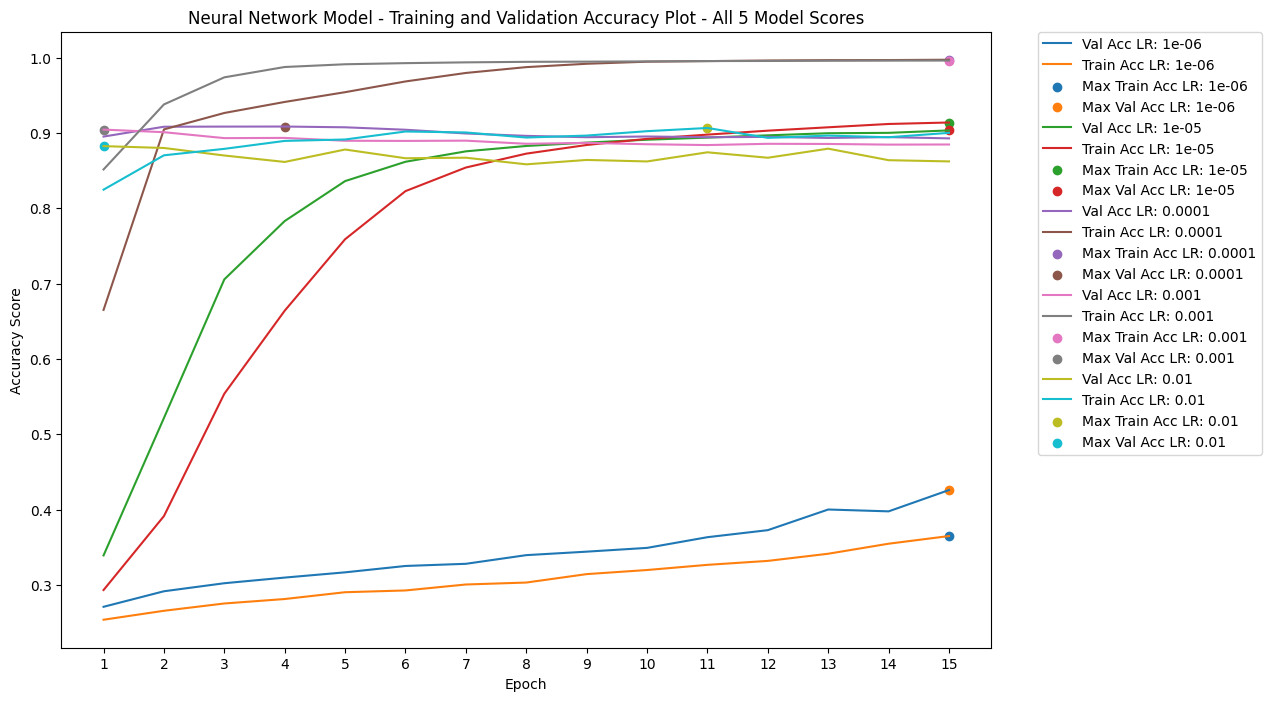

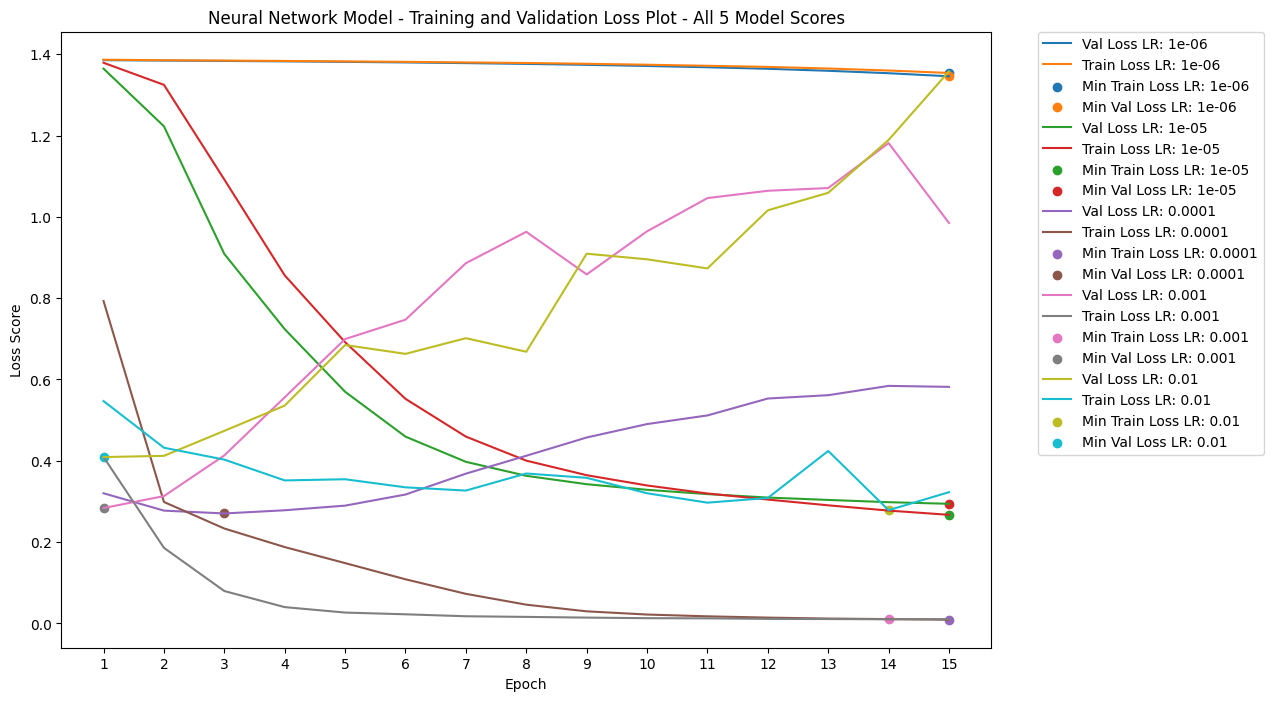

In [15]:
# Placeholders
lr_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
history_val_acc_list, history_trn_acc_list = [], []
history_val_loss_list, history_trn_loss_list = [], []

# Loop
for lr in lr_list:
    # Clear Session
    clear_session()
    gc.collect()
    
    # Create model
    model = Sequential()
    model.add(Embedding(max_words, embedding_size, input_length = max_length))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(learning_rate = lr), 
                  metrics = ['accuracy'])

    # Fit Model and Validate
    history = model.fit(x_train, 
                        y_train, 
                        validation_data = (x_valid, y_valid), 
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = 0)
    
    # Best Result
    print(f'Best Validation Accuracy for Learning Rate: {lr} is: {max(history.history["val_accuracy"])}')
    
    # Add Metrics to list
    history_val_acc_list.append(history.history['val_accuracy'])
    history_trn_acc_list.append(history.history['accuracy'])
    history_val_loss_list.append(history.history['val_loss'])
    history_trn_loss_list.append(history.history['loss'])

# Plot results
plot_results_accuracy('Neural Network Model', epochs, lr_list, history_val_acc_list, history_trn_acc_list)
plot_results_loss('Neural Network Model', epochs, lr_list, history_val_loss_list, history_trn_loss_list)

### 4.1 LSTM Model

The second model we will use for the experiments is a 2 layer LSTM Model.

The experiment setup is similar to the first one. The model will be trained and validated on a number of epochs for each of the different learning rates.

As a final step the performance metrics will be plotted for all results.

Best Validation Accuracy for Learning Rate: 1e-06 is: 0.5601666569709778
Best Validation Accuracy for Learning Rate: 1e-05 is: 0.8872083425521851
Best Validation Accuracy for Learning Rate: 0.0001 is: 0.9038333296775818
Best Validation Accuracy for Learning Rate: 0.001 is: 0.9082916378974915
Best Validation Accuracy for Learning Rate: 0.01 is: 0.9035000205039978


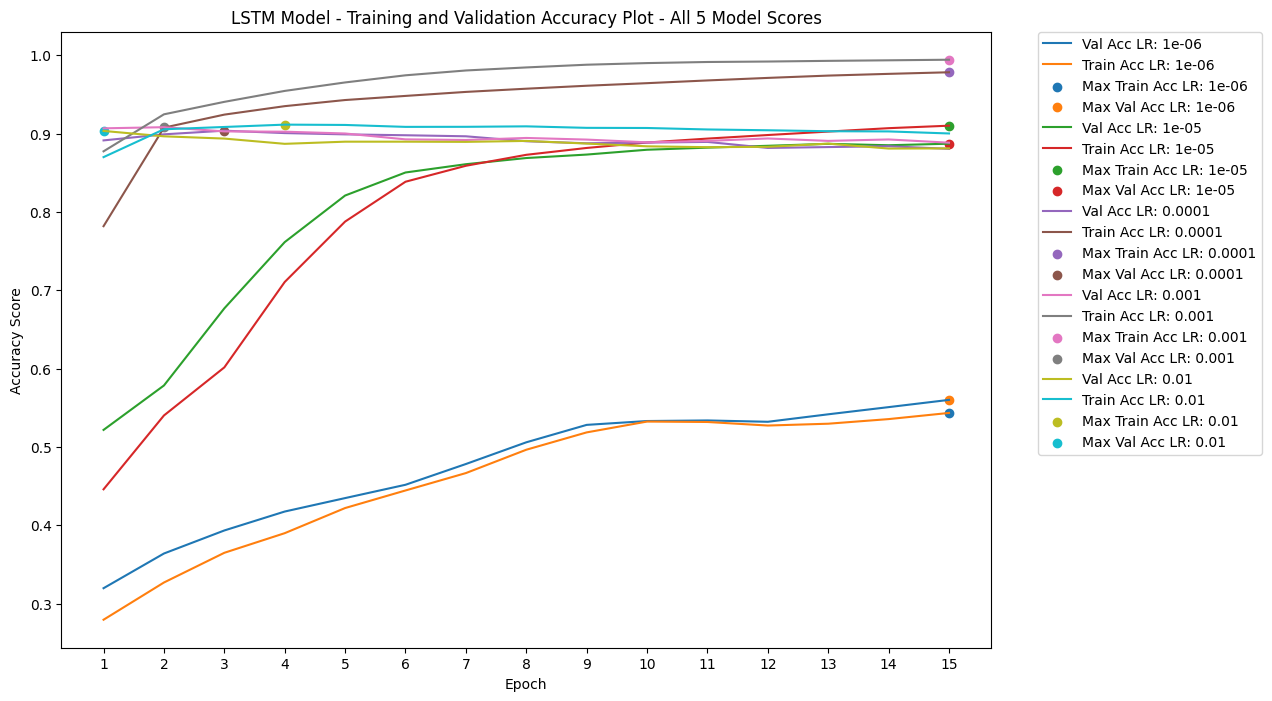

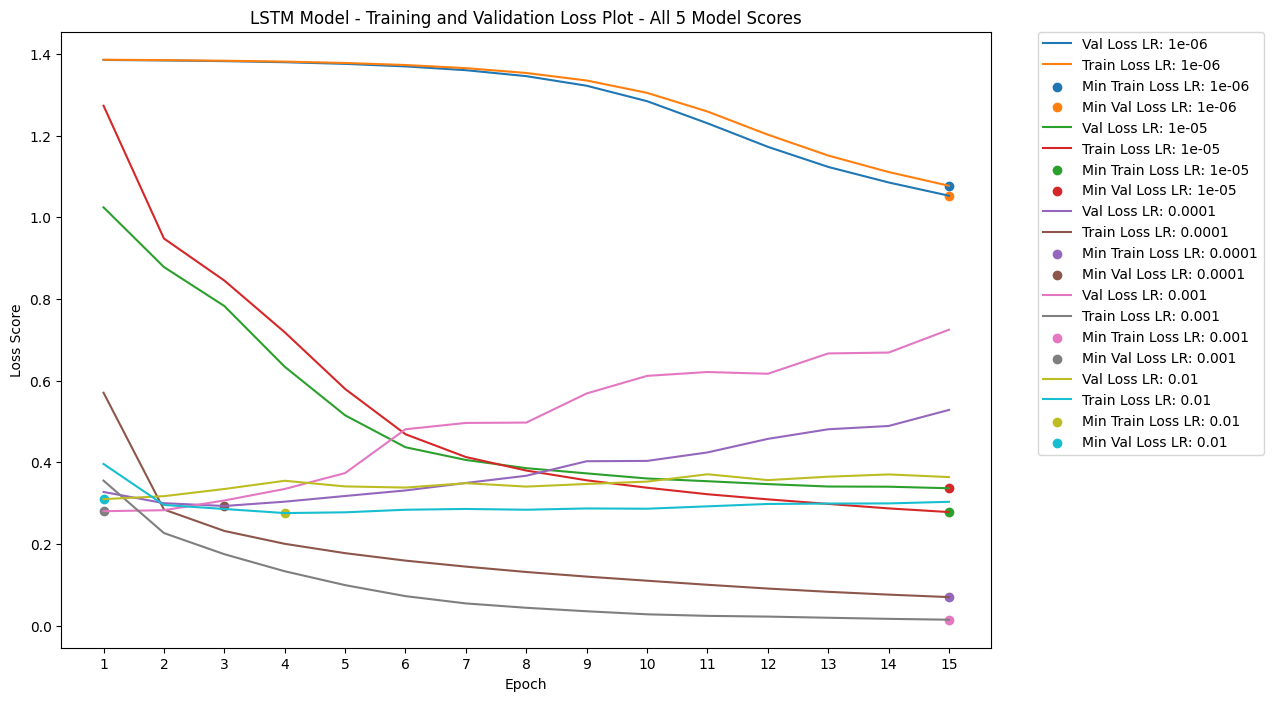

In [16]:
# Placeholders
lr_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
history_val_acc_list, history_trn_acc_list = [], []
history_val_loss_list, history_trn_loss_list = [], []

# Loop
for lr in lr_list:
    # Clear Session
    clear_session()
    gc.collect()
    
    # Create model
    model = Sequential()
    model.add(Embedding(max_words, embedding_size, input_length = max_length))
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(0.25))
    model.add(LSTM(64))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(learning_rate = lr), 
                  metrics = ['accuracy'])

    # Fit Model and Validate
    history = model.fit(x_train, 
                        y_train, 
                        validation_data = (x_valid, y_valid), 
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = 0)
    
    # Best Result
    print(f'Best Validation Accuracy for Learning Rate: {lr} is: {max(history.history["val_accuracy"])}')
    
    # Add Metrics to list
    history_val_acc_list.append(history.history['val_accuracy'])
    history_trn_acc_list.append(history.history['accuracy'])
    history_val_loss_list.append(history.history['val_loss'])
    history_trn_loss_list.append(history.history['loss'])

# Plot results
plot_results_accuracy('LSTM Model', epochs, lr_list, history_val_acc_list, history_trn_acc_list)
plot_results_loss('LSTM Model', epochs, lr_list, history_val_loss_list, history_trn_loss_list)

### 4.2 DistilBert Transformers Model

The last model we will experiment with is a DistilBert Transformers model. The DistilBert model is a small Transformers model with little over 60 million parameters. Compared to the multi billion parameter Large Language Models that are currently available this is really small and yet it allows for some interresting experiments.

The neural network and LSTM model from our first 2 experiments were trained from scratch. The DistilBert model was however pre-trained on Gigabytes of text. What we will perform now is basically that we fine-tune the DistilBert model on our own dataset.

Based on some experiments before the final run there are 2 things that we change compared to the previous experiments:
1. Less epochs. The DistilBert mode requires a lot less epochs to achieve good performance and each epoch takes a lot longer compared to the first 2 models.
2. Remove the 2 highest learning rates from the list that will be trained on. DistilBert works only on very low learning rates.

Next we will setup the required configuration and tokenizer for DistilBert. We also define a function to tokenize the text specifically for DistilBert and convert it into a Tensorflow Dataset.

In [17]:
# Set Model Type
model_type = 'distilbert-base-cased'

# Create AutoConfig
config = AutoConfig.from_pretrained(model_type, 
                                    num_labels = 4)

# Set Tokenizer
autotokenizer = AutoTokenizer.from_pretrained(model_type, 
                                              add_prefix_space = False, 
                                              do_lower_case = False)

def tokenize_text(df, max_length, batch_size):
    # Placeholders input
    input_ids, input_masks = [], []    

    # Tokenize Eescription
    for index, row in df.iterrows():        
        input_encoded = autotokenizer.encode_plus(row['description'], add_special_tokens = True, max_length = max_length, truncation = True, padding = 'max_length')
        input_ids.append(input_encoded['input_ids'])
        input_masks.append(input_encoded['attention_mask'])
    
    # Get Labels
    labels = df.label.values

    # Create TF Dataset
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tf.Variable(input_ids), 'attention_mask': tf.Variable(input_masks)}, tf.Variable(labels)))
    dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

Next we will run the first experiment with the DistilBert model.

Note that we try only the 3 lowest learning rates and train the model only for 6 epochs.

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Best Validation Accuracy for Learning Rate: 1e-06 is: 0.9267916679382324


Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Best Validation Accuracy for Learning Rate: 1e-05 is: 0.9321249723434448


Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Best Validation Accuracy for Learning Rate: 0.0001 is: 0.924916684627533


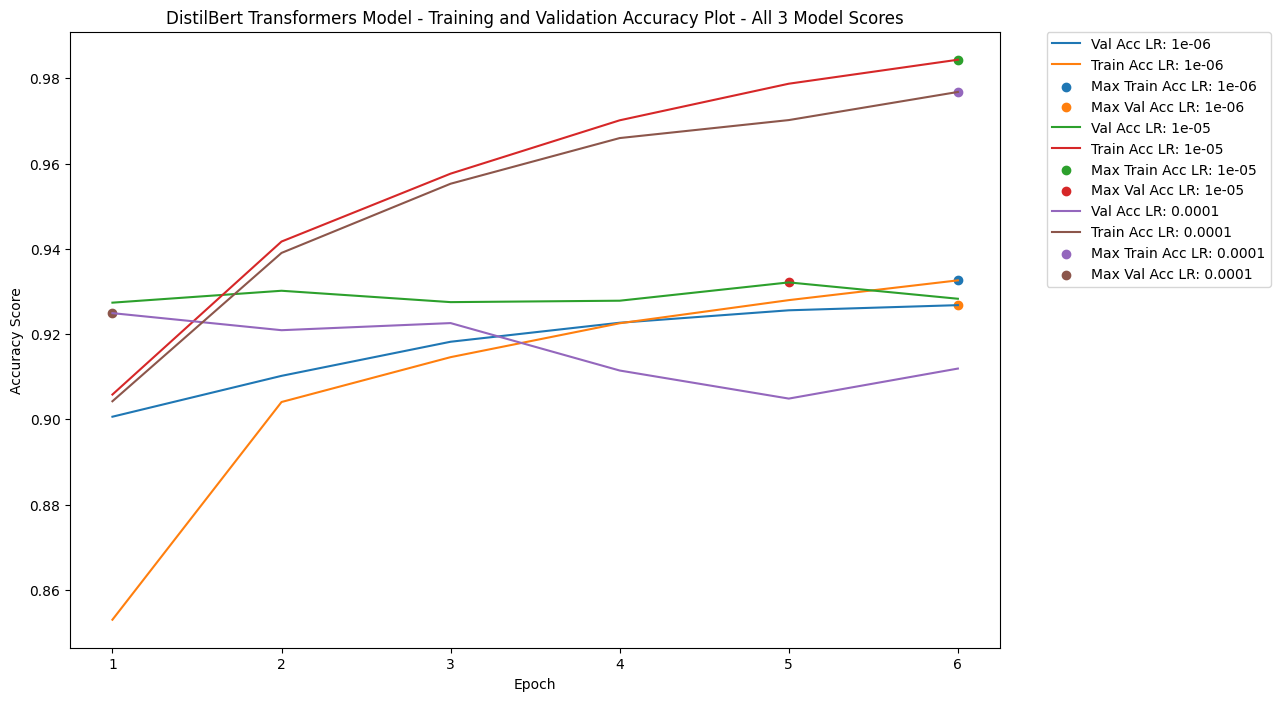

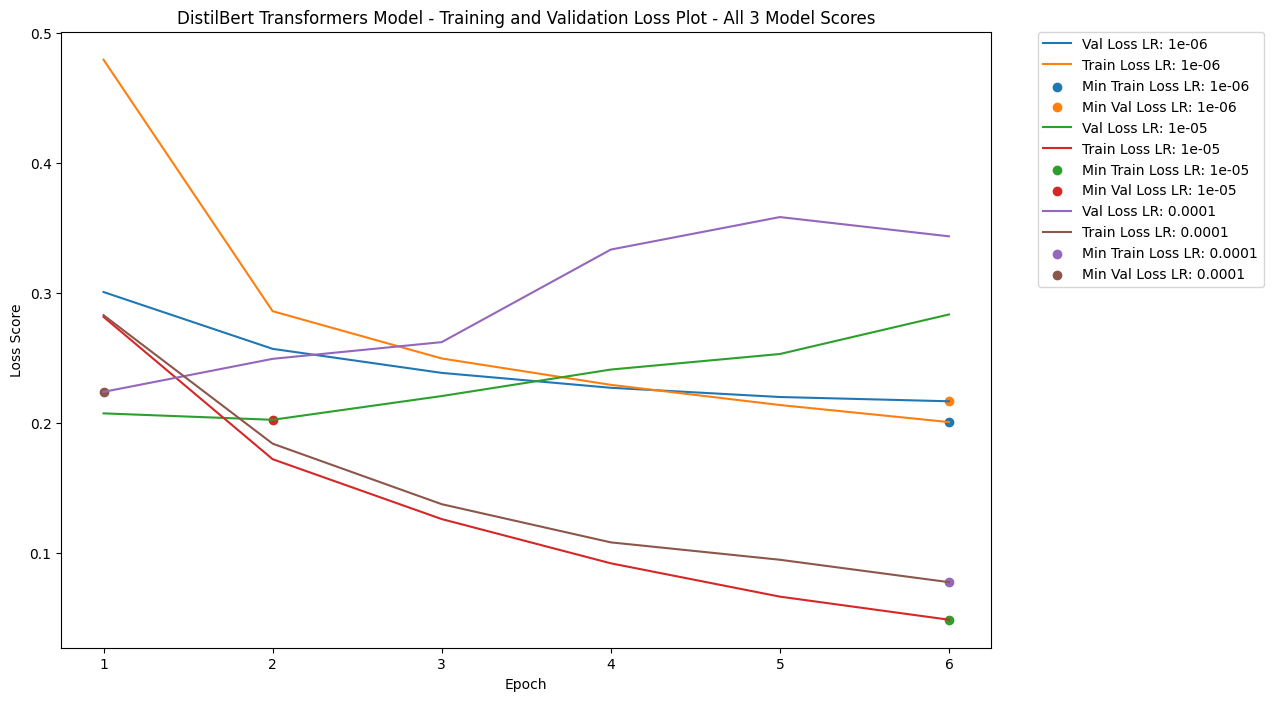

In [18]:
# Constants for Transformers Model
max_length = 96
batch_size = 32
epochs = 6

# Tokenize for Transformers Model
train_set = tokenize_text(trn_df, max_length, batch_size)
val_set = tokenize_text(val_df, max_length, batch_size)

# Placeholders
lr_list = [0.000001, 0.00001, 0.0001]
history_val_acc_list, history_trn_acc_list = [], []
history_val_loss_list, history_trn_loss_list = [], []

# Loop
for lr in lr_list:
    # Clear Session
    clear_session()
    gc.collect()
    
    # Create model
    model = TFDistilBertForSequenceClassification.from_pretrained(model_type, config = config)        
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                  metrics = ['accuracy'])
    
    # Fit Model and Validate
    history = model.fit(train_set,
                        validation_data = val_set, 
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = 0)
    
    # Best Result
    print(f'Best Validation Accuracy for Learning Rate: {lr} is: {max(history.history["val_accuracy"])}')
    
    # Add Metrics to list
    history_val_acc_list.append(history.history['val_accuracy'])
    history_trn_acc_list.append(history.history['accuracy'])
    history_val_loss_list.append(history.history['val_loss'])
    history_trn_loss_list.append(history.history['loss'])

# Plot results
plot_results_accuracy('DistilBert Transformers Model', epochs, lr_list, history_val_acc_list, history_trn_acc_list)
plot_results_loss('DistilBert Transformers Model', epochs, lr_list, history_val_loss_list, history_trn_loss_list)

In this experiment we can see in the loss plot that only for the lowest learning rate the validation loss keeps declinining. For the 2 higher learning rates the validation loss increases already after the first or second epoch showing signs of slightly overfitting.

The tokenization proces as was used for the neural network and the LSTM model tokenized the cleaned text based on the whole words. The DistilBert tokenizer uses the original uncleaned text and also because of the pretraining has a vocabulary based on which sometimes a word is tokenized in multiple parts. If we use the max_length as specified for the neural network and LSTM than that might be to short for the DistilBert model.

Lets perform one more experiment based on the lowest learning rate. This time we will double the max_length and see what the results are then compared to the first DistilBert experiment.

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Best Validation Accuracy for Learning Rate: 1e-06 is: 0.9293749928474426


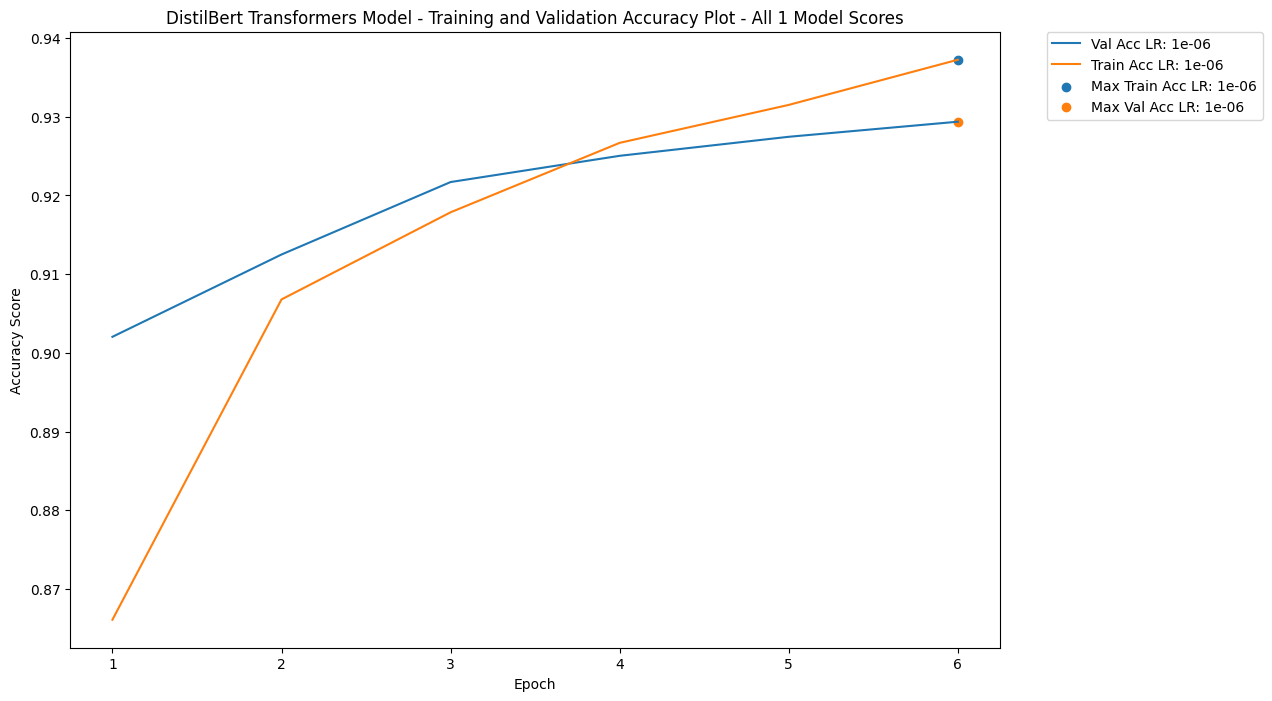

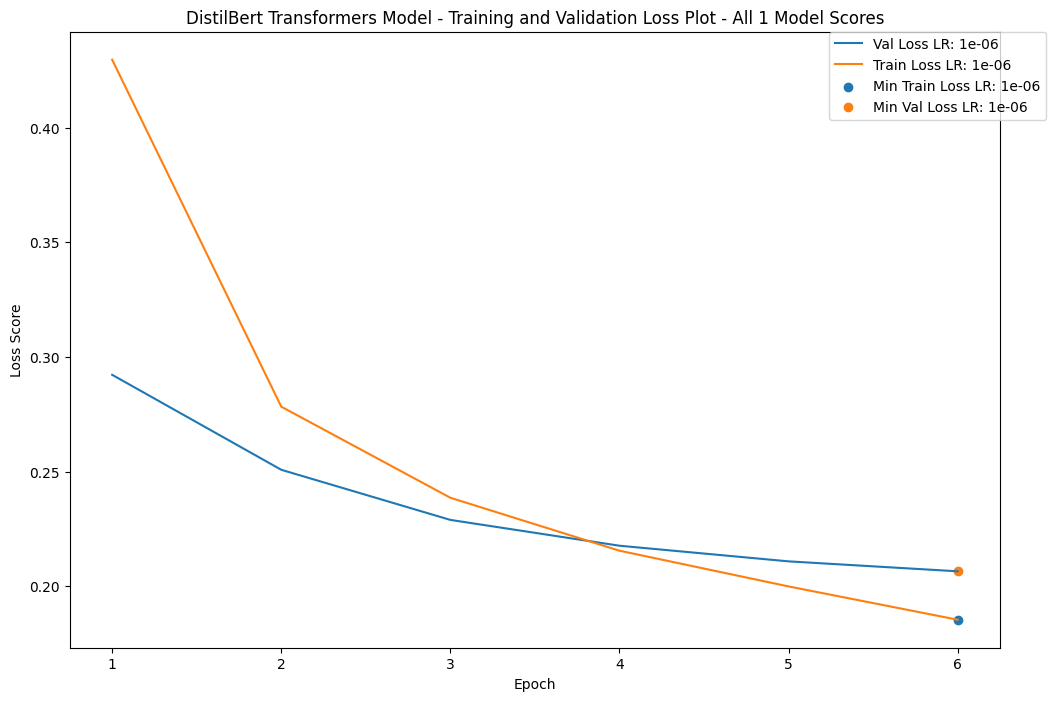

In [21]:
# Constants for Transformers Model
max_length = 192
batch_size = 20
epochs = 6

# Tokenize for Transformers Model
train_set = tokenize_text(trn_df, max_length, batch_size)
val_set = tokenize_text(val_df, max_length, batch_size)

# Placeholders
lr_list = [0.000001]
history_val_acc_list, history_trn_acc_list = [], []
history_val_loss_list, history_trn_loss_list = [], []

# Loop
for lr in lr_list:
    # Clear Session
    clear_session()
    gc.collect()
    
    # Create model
    model = TFDistilBertForSequenceClassification.from_pretrained(model_type, config = config)        
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])
    
    # Fit Model and Validate
    history = model.fit(train_set,
                        validation_data = val_set, 
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = 0)
    
    # Best Result
    print(f'Best Validation Accuracy for Learning Rate: {lr} is: {max(history.history["val_accuracy"])}')
    
    # Add Metrics to list
    history_val_acc_list.append(history.history['val_accuracy'])
    history_trn_acc_list.append(history.history['accuracy'])
    history_val_loss_list.append(history.history['val_loss'])
    history_trn_loss_list.append(history.history['loss'])

# Plot results
plot_results_accuracy('DistilBert Transformers Model', epochs, lr_list, history_val_acc_list, history_trn_acc_list)
plot_results_loss('DistilBert Transformers Model', epochs, lr_list, history_val_loss_list, history_trn_loss_list)

## 5. Results and Analysis

The neural network model achieves it highest accuracy of 90.8% at a learning rate of 0.0001. The loss plot shows very clearly that the highest and lowest learning rates lead to overfitting and underfitting of the model.

The LSTM model achieves the highest accuracy of 90.8% at a learning rate of 0.001. The plots of the metrics show a similar pattern compared to the neural network of either over or underfitting for to high or to low learning rates.

The fact that most surprised me was that both models achieved a similar accuracy of 90.8%. Given that an LSTM model should be a better fit for text sequences I would have expected  a slightly higher accuracy for the LSTM model. I have no clear explanation for this. It might be that with further hyperparameter tuning the performance of the LSTM model could be improved.

In our last experiment we used the DistilBert Transformers model. It achieved a highest accuracy of 93.2% with a learning rate of 0.00001 at the 5th epoch. This performance is significantly higher than the neural network model and LSTM model.

This performance increase clearly shows the benefits of using a pre-trained model with the Transformers architecture. Given that there are significantly larger / better performing Transformer models available the achieved performance could be pushed further.

During some experiments with DistilBert before the final runs I noticed that DistilBert (and likely also other similar Transformer models) is very sensitive to the learning rate. Therefore I decided to skip the highest 2 learning rates in the final experiments. Also only a few epochs are required to train the model.

The fact that only a few epochs are required for DistilBert does not mean that the model is fast to train. With the number of parameters for the DistilBert model each epoch takes almost 10 minutes on my laptop. If we compare this to the neural network for which each epoch takes around 10 seconds.

When applying these models in real life this makes for an interresting choice. Is the additional accuracy worth the higher amount of compute time required?

## 6. Conclusion

In this notebook we explored and analyzed using a neural network model, LSTM model and a DistilBert Transformers model to perform a classification task on the medium sized NLP AG News Subset dataset.

Besides being able to compare the models among each other we went even further and trained each model on a number of different learning rates. The various plots of the learning rates versus the loss and accuracy at each epoch showed that indeed a to low learning rate makes the model underfitting on the data and a to high a learning rate makes the model overfit on the data.
Selecting the right learning rate for the model and dataset is an important part of the hyperparameter tuning.

While the neural network model and LSTM model have very similar performance (I was actually surprised about that..I would have expected the LSTM model to have higher performance compared to the neural network model) the DistilBert Transformers model has a clear advantage of being pre-trained on a large amount of text. It achieves the highest performance after only a few epochs of training on a very low learning rate.

Given that there are even better performing and larger sizes of transformer models available the achieved accuracy could likely be pushed a lot higher.

## 7. References

The following URL's where used for some reference material. 

1. https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.TFDistilBertForSequenceClassification
2. https://keras.io/examples/